In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import files
trainHouseCSV = files.upload()

trainHouse = pd.read_csv('train.csv')
trainHouse.head()

Saving train.csv to train.csv


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
trainHouse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: xlabel='SalePrice', ylabel='Count'>

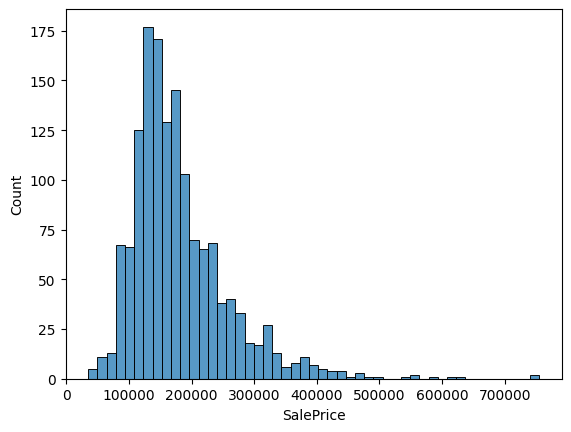

In [4]:
sns.histplot(trainHouse['SalePrice'])

In [5]:
X = trainHouse.drop('SalePrice', axis=1)
y = trainHouse['SalePrice']

In [6]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

def preprocess_house_data(df):
    df = df.copy()

    categorical_cols = df.select_dtypes(include="object").columns
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

    # Drop columns
    cols_to_drop = ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']
    df = df.drop(cols_to_drop, axis=1, errors='ignore') # Use errors='ignore' in case a column doesn't exist

    # -- Impute missing values --
    # with mean
    if 'MasVnrArea' in df.columns:
        df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace=True)

    # Impute remaining categorical columns with mode, fallback to -1
    categorical_cols_remaining = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical']
    for col in categorical_cols_remaining:
         if col in df.columns:
            df[col].fillna(df[col].mode().iloc[0] if not df[col].mode().empty else np.nan, inplace=True)

    # 'LotFrontage'
    if 'LotFrontage' in df.columns and 'BldgType' in df.columns:
        df['LotFrontage'] = df.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
        df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)
    elif 'LotFrontage' in df.columns:
         df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)


    #'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'
    # Using 'YearBuilt' -> mode/mean
    garage_cols_to_impute = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
    for col in garage_cols_to_impute:
        if col in df.columns:
            if df[col].dtype in ['int64', 'float64']:
                if 'YearBuilt' in df.columns:
                     df[col] = df.groupby('YearBuilt')[col].transform(lambda x: x.fillna(x.mean()))
                df[col].fillna(df[col].mean(), inplace=True)
            else:
                if 'YearBuilt' in df.columns:
                     df[col] = df.groupby('YearBuilt')[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
                df[col].fillna(df[col].mode().iloc[0] if not df[col].mode().empty else np.nan, inplace=True)

    # -- Feature Engineering --
    # 'OverallQual'
    if 'OverallQual' in df.columns and 'OverallCond' in df.columns:
        df['OverallQual_Cond'] = df['OverallQual'] * df['OverallCond']
    else:
        df['OverallQual_Cond'] = 0


    # 'House_Age'
    if 'YrSold' in df.columns and 'YearBuilt' in df.columns:
         df['House_Age'] = df['YrSold'] - df['YearBuilt']
    else:
        df['House_Age'] = 0

    # 'Years_Since_Remodel'
    if 'YrSold' in df.columns and 'YearRemodAdd' in df.columns:
        df['Years_Since_Remodel'] = df['YrSold'] - df['YearRemodAdd']
        df['Years_Since_Remodel'] = df.apply(lambda row: row['House_Age'] if row['Years_Since_Remodel'] < 0 else row['Years_Since_Remodel'], axis=1)
    else:
         df['Years_Since_Remodel'] = 0


    # 'TotalSF'
    if '1stFlrSF' in df.columns and '2ndFlrSF' in df.columns:
        df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    else:
        df['TotalSF'] = 0 # Default if columns missing


    return df

In [14]:
X = preprocess_house_data(X)
display(X)

/tmp/ipython-input-6-736999423.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace=True)
/tmp/ipython-input-6-736999423.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,OverallQual_Cond,House_Age,Years_Since_Remodel,TotalSF
0,1,60,3.0,65.0,8450,1.0,3.0,3.0,0.0,4.0,...,0,0,2,2008,8.0,4.0,35,5,5.0,1710
1,2,20,3.0,80.0,9600,1.0,3.0,3.0,0.0,2.0,...,0,0,5,2007,8.0,4.0,48,31,31.0,1262
2,3,60,3.0,68.0,11250,1.0,0.0,3.0,0.0,4.0,...,0,0,9,2008,8.0,4.0,35,7,6.0,1786
3,4,70,3.0,60.0,9550,1.0,0.0,3.0,0.0,0.0,...,0,0,2,2006,8.0,0.0,35,91,36.0,1717
4,5,60,3.0,84.0,14260,1.0,0.0,3.0,0.0,2.0,...,0,0,12,2008,8.0,4.0,40,8,8.0,2198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3.0,62.0,7917,1.0,3.0,3.0,0.0,4.0,...,0,0,8,2007,8.0,4.0,30,8,7.0,1647
1456,1457,20,3.0,85.0,13175,1.0,3.0,3.0,0.0,4.0,...,0,0,2,2010,8.0,4.0,36,32,22.0,2073
1457,1458,70,3.0,66.0,9042,1.0,3.0,3.0,0.0,4.0,...,0,2500,5,2010,8.0,4.0,63,69,4.0,2340
1458,1459,20,3.0,68.0,9717,1.0,3.0,3.0,0.0,4.0,...,0,0,4,2010,8.0,4.0,30,60,14.0,1078


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

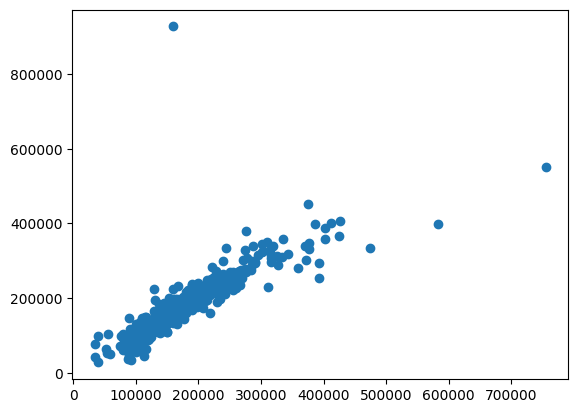

In [16]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)

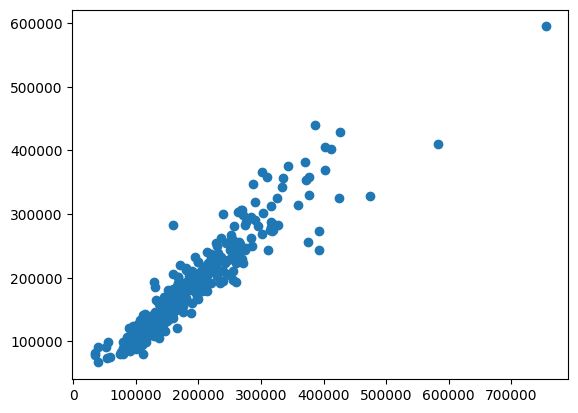

In [17]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=101)
xgb_model.fit(X_train, y_train)

predictions_xgb = xgb_model.predict(X_test)

plt.scatter(y_test,predictions_xgb)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))
print(f"\nTHE BEST\nXGBoost Regressor MAE: {mae_xgb}")
print(f"XGBoost Regressor RMSE: {rmse_xgb}")

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=101),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best negative MSE found: ", grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}
Best negative MSE found:  -805362598.4



Best XGBoost Regressor MAE: 14831.267578125
Best XGBoost Regressor RMSE: 23921.748431082542


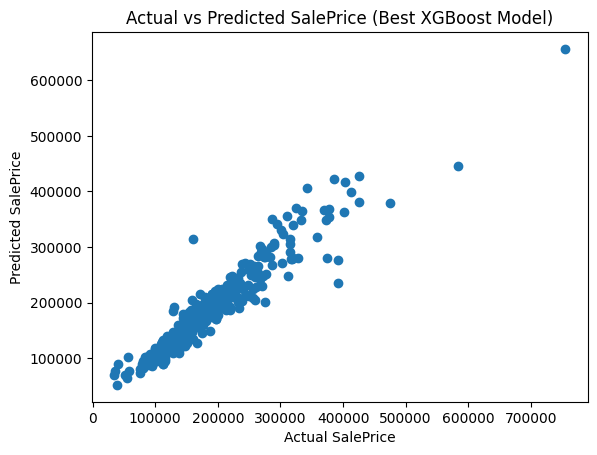

In [25]:
predictions_best_xgb = best_xgb_model.predict(X_test)

mae_best_xgb = mean_absolute_error(y_test, predictions_best_xgb)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, predictions_best_xgb))

print(f"\nBest XGBoost Regressor MAE: {mae_best_xgb}")
print(f"Best XGBoost Regressor RMSE: {rmse_best_xgb}")

plt.scatter(y_test, predictions_best_xgb)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (Best XGBoost Model)")
plt.show()

In [26]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

predictions_best_xgb_positive = np.maximum(0, predictions_best_xgb)

msle_best_xgb = mean_squared_log_error(y_test, predictions_best_xgb_positive)

rmsle_best_xgb = np.sqrt(msle_best_xgb)

print(f"Best XGBoost Regressor RMSLE: {rmsle_best_xgb}")

Best XGBoost Regressor RMSLE: 0.1276373909171515


In [27]:
from google.colab import files
testHouseCSV = files.upload()

testHouse = pd.read_csv('test.csv')
testHouse.head()

Saving test.csv to test.csv


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [28]:
XtestHouse = preprocess_house_data(testHouse)
display(XtestHouse)

/tmp/ipython-input-6-736999423.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace=True)
/tmp/ipython-input-6-736999423.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,OverallQual_Cond,House_Age,Years_Since_Remodel,TotalSF
0,1461,20,2.0,80.0,11622,1.0,3.0,3.0,0.0,4.0,...,0,0,6,2010,8.0,4.0,30,49,49.0,896
1,1462,20,3.0,81.0,14267,1.0,0.0,3.0,0.0,0.0,...,0,12500,6,2010,8.0,4.0,36,52,52.0,1329
2,1463,60,3.0,74.0,13830,1.0,0.0,3.0,0.0,4.0,...,0,0,3,2010,8.0,4.0,25,13,12.0,1629
3,1464,60,3.0,78.0,9978,1.0,0.0,3.0,0.0,4.0,...,0,0,6,2010,8.0,4.0,36,12,12.0,1604
4,1465,120,3.0,43.0,5005,1.0,0.0,1.0,0.0,4.0,...,0,0,1,2010,8.0,4.0,40,18,18.0,1280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,4.0,21.0,1936,1.0,3.0,3.0,0.0,4.0,...,0,0,6,2006,8.0,4.0,28,36,36.0,1092
1455,2916,160,4.0,21.0,1894,1.0,3.0,3.0,0.0,4.0,...,0,0,4,2006,8.0,0.0,20,36,36.0,1092
1456,2917,20,3.0,160.0,20000,1.0,3.0,3.0,0.0,4.0,...,0,0,9,2006,8.0,0.0,35,46,10.0,1224
1457,2918,85,3.0,62.0,10441,1.0,3.0,3.0,0.0,4.0,...,0,700,7,2006,8.0,4.0,25,14,14.0,970


In [29]:
predictions_testHouse = best_xgb_model.predict(XtestHouse)

In [31]:
submission_df = pd.DataFrame({
    'Id': range(1461, 1461 + len(predictions_testHouse)),
    'SalePrice': predictions_testHouse
})

display(submission_df.head())

,Id,SalePrice
0,1461,127360.195312
1,1462,170961.718750
2,1463,177861.421875
3,1464,192446.656250
4,1465,193082.046875


from matplotlib import pyplot as plt
_df_0['Id'].plot(kind='hist', bins=20, title='Id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['SalePrice'].plot(kind='hist', bins=20, title='SalePrice')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Id', y='SalePrice', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Id'}, axis=1)
              .sort_values('Id', ascending=True))
  xs = counted['Id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['SalePrice']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'SalePrice'}, axis=1)
              .sort_values('SalePrice', ascending=True))
  xs = counted['SalePrice']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('SalePrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SalePrice')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Id'].plot(kind='line', figsize=(8, 4), title='Id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['SalePrice'].plot(kind='line', figsize=(8, 4), title='SalePrice')
plt.gca().spines[['top', 'right']].set_visible(False)

In [34]:
submission_df.to_csv('submissionPredictHouseFinal.csv', index=False)